<h1>NHẬP DỮ LIỆU</h1>

In [21]:
import pandas as pd
df = pd.read_csv('NordpoolMarket.csv', sep=';', engine='python')
print(df.head())

            HourUTC            HourDK PriceArea SpotPurchase  SpotSale  \
0  2021-04-30 21:00  2021-04-30 23:00       DK1     0,000000  0,000000   
1  2021-04-30 21:00  2021-04-30 23:00       DK2   776,000000  0,000000   
2  2021-04-30 20:00  2021-04-30 22:00       DK1     0,000000  0,000000   
3  2021-04-30 20:00  2021-04-30 22:00       DK2   762,000000  0,000000   
4  2021-04-30 19:00  2021-04-30 21:00       DK1     0,000000  0,000000   

  SpotPriceDKK ElbasAveragePriceDKK ElbasMaxPriceDKK ElbasMinPriceDKK  \
0   512,020020                  NaN              NaN              NaN   
1   512,020020                  NaN              NaN              NaN   
2   559,390015           472,706512       488,470825       456,496033   
3   559,390015           484,009247       489,214447       479,398926   
4   585,260010           542,604919       557,105103       526,022644   

  SpotPriceEUR ElbasAveragePriceEUR ElbasMaxPriceEUR ElbasMinPriceEUR  
0    68,860001                  NaN         

<h1> XỬ LÝ GIÁ TRỊ THIẾU </h1>

In [22]:
import pandas as pd

# Đọc dữ liệu (sửa phân cách nếu cần)
df = pd.read_csv('NordpoolMarket.csv', sep=';', engine='python')

# Chọn cột cần thiết
df = df[['HourUTC', 'PriceArea', 'SpotPriceEUR']]

# Chuyển dấu phẩy thành dấu chấm để ép kiểu float
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.', regex=False)

# Ép kiểu float
df['SpotPriceEUR'] = pd.to_numeric(df['SpotPriceEUR'], errors='coerce')

# Chuyển HourUTC thành datetime
df['HourUTC'] = pd.to_datetime(df['HourUTC'])

# Lọc theo khu vực (VD: DK1)
df = df[df['PriceArea'] == 'DK1']

# Đặt HourUTC làm chỉ số thời gian
df.set_index('HourUTC', inplace=True)

# Sắp xếp theo thời gian
df.sort_index(inplace=True)

# Nội suy giá trị thiếu (linear interpolation theo thời gian)
df['SpotPriceEUR'] = df['SpotPriceEUR'].interpolate(method='time')

# (Tuỳ chọn) Xoá hàng còn thiếu sau nội suy nếu có
df.dropna(inplace=True)

# Kết quả
print(df.head())


                    PriceArea  SpotPriceEUR
HourUTC                                    
2015-08-30 22:00:00       DK1     18.910000
2015-08-30 23:00:00       DK1     18.370001
2015-08-31 00:00:00       DK1     18.150000
2015-08-31 01:00:00       DK1     18.270000
2015-08-31 02:00:00       DK1     18.620001


<h1> MÔ HÌNH HMM </h1>

/var/folders/wz/kd4_t7f133354hzlh56ptt240000gn/T/ipykernel_3774/2158498595.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SpotPriceEUR'].interpolate(method='time', inplace=True)


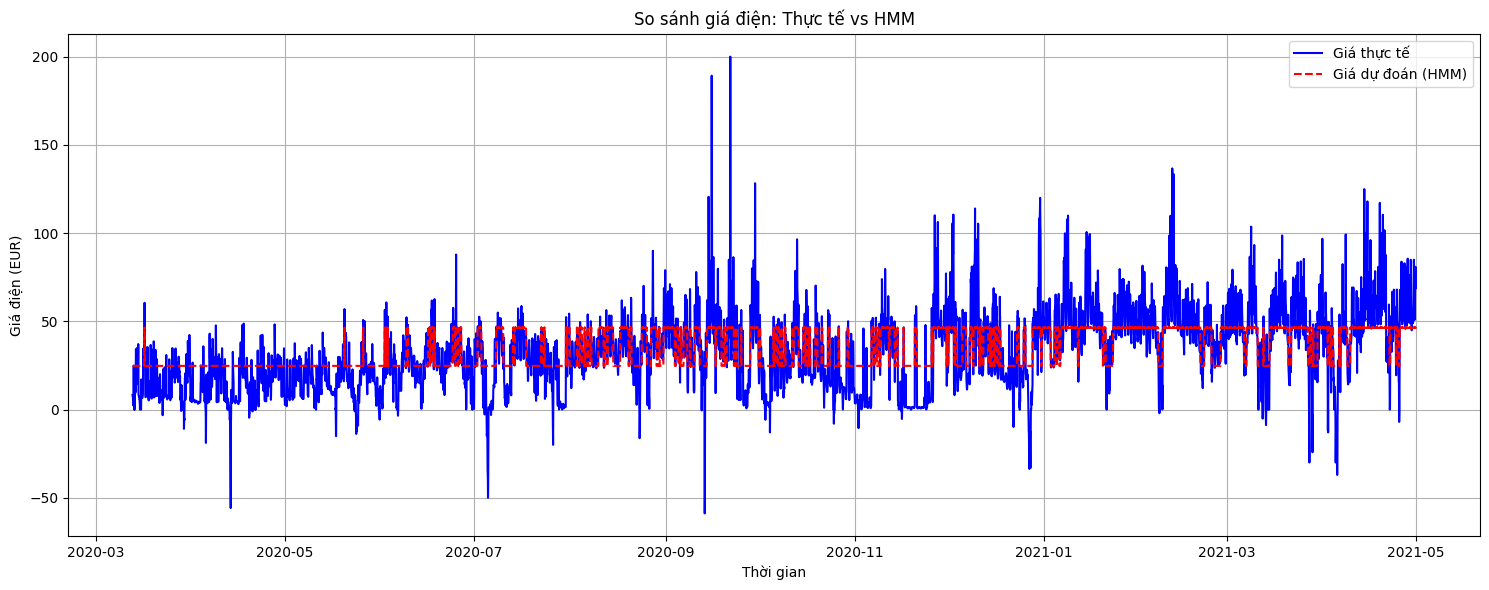

  Chỉ số    Giá trị
0   RMSE  14.805690
1    MAE  10.922935


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---- Load and preprocess your data ----
df = pd.read_csv("NordpoolMarket.csv", sep=';', parse_dates=['HourUTC'])

# Convert price to float (fix comma to dot)
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)

# Filter for DK1 region
df = df[df['PriceArea'] == 'DK1']

# Set time index
df.set_index('HourUTC', inplace=True)

# Sort and fill missing values
df.sort_index(inplace=True)
df['SpotPriceEUR'].interpolate(method='time', inplace=True)
df.dropna(subset=['SpotPriceEUR'], inplace=True)

# ---- Train/Test split ----
n = len(df)
train_size = int(n * 0.8)
train_data = df['SpotPriceEUR'].values[:train_size].reshape(-1, 1)
test_data = df['SpotPriceEUR'].values[train_size:].reshape(-1, 1)
test_index = df.index[train_size:]

# ---- Train Gaussian HMM ----
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
model.fit(train_data)

# ---- Predict states ----
predicted_states = model.predict(test_data)
state_means = model.means_.flatten()
predicted_prices = state_means[predicted_states]

# ---- Evaluation ----
rmse = np.sqrt(mean_squared_error(test_data.flatten(), predicted_prices))
mae = mean_absolute_error(test_data.flatten(), predicted_prices)

# ---- Plot ----
plt.figure(figsize=(15, 6))
plt.plot(test_index, test_data, label='Giá thực tế', color='blue')
plt.plot(test_index, predicted_prices, label='Giá dự đoán (HMM)', color='red', linestyle='--')
plt.title('So sánh giá điện: Thực tế vs HMM')
plt.xlabel('Thời gian')
plt.ylabel('Giá điện (EUR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Print metrics ----
metrics = pd.DataFrame({
    'Chỉ số': ['RMSE', 'MAE'],
    'Giá trị': [rmse, mae]
})
print(metrics)
